<a href="https://colab.research.google.com/github/Jax45/Deepfake-Detection/blob/main/Deepfake_Detection_Phase_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5390 Deep Learning UMSL
## sp21 Semester Project
Jackson Hoenig

# Description

1.  Watch the lectures in Module 9.
2.  Use pretrained models such as VGG16 or ResNet50 and retrain using your dataset.
3.  Use recent architectures such as ResNet, DenseNet, or NASNet to train a model and study the improvement in accuracy
4.  Plot your learning curves and include them in your report

#Initial Setup

##Imports

In [1]:
# !pip install tensorflow==2.2.0
import tensorflow
print(tensorflow.__version__)

2.4.1


In [2]:
import requests, zipfile, io, os
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras import callbacks
from keras.layers import Dropout
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

In [3]:
#Make sure the Earlystop callback is used with the validation set
callback = callbacks.EarlyStopping(monitor='val_loss', patience=5)

##Prevent Google Colab From Stalling

In [4]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button"); 
     btn.click() 
     }
   
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect"); 
     btn.click() 
     }
  }
  
setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


#Split the Training Data

In [5]:
print('Downloading and unzipping test file.')
r = requests.get('https://github.com/Jax45/Deepfake-Detection/raw/main/DeepfakeDataset-001.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [6]:
#create the directory paths
!mkdir SplitDataset
!mkdir SplitDataset/train
!mkdir SplitDataset/test
!mkdir SplitDataset/valid
!mkdir SplitDataset/train/real
!mkdir SplitDataset/train/fake
!mkdir SplitDataset/test/real
!mkdir SplitDataset/test/fake
!mkdir SplitDataset/valid/real
!mkdir SplitDataset/valid/fake

In [7]:
# !rm SplitDataset/train/real/*
# !rm SplitDataset/train/fake/*
# !rm SplitDataset/test/real/*
# !rm SplitDataset/test/fake/*
# !rm SplitDataset/valid/real/*
# !rm SplitDataset/valid/fake/*
# !rmdir SplitDataset/train/real
# !rmdir SplitDataset/train/fake
# !rmdir SplitDataset/test/real
# !rmdir SplitDataset/test/fake
# !rmdir SplitDataset/valid/real
# !rmdir SplitDataset/valid/fake
# !rmdir SplitDataset/train
# !rmdir SplitDataset/test
# !rmdir SplitDataset/valid
# !rmdir -p SplitDataset

In [8]:

#save all real file names to list
import os
count = 0
realFileNames = list()
fakeFileNames = list()
for filename in os.listdir('/content/Real_Images'):
  realFileNames.append(filename)

#save all fake file names to list
for filename in os.listdir('/content/Fake_Images'):
  fakeFileNames.append(filename)



In [9]:
import random
import os
import imageio
#split real file names into
#train valid and test
#random.shuffle(realFileNames)
count = 0
for file in realFileNames:
  if count % 5 == 0 or count % 5 == 2 or count % 5 == 4: #first 60%
    # print("Train dataset" + str(count))
    imageio.imwrite('/content/SplitDataset/train/real/' + file, imageio.imread('/content/Real_Images/' + file))

  elif count % 5 == 1: #20% after 60%
    # print("Valid dataset" + str(count))
    imageio.imwrite('/content/SplitDataset/valid/real/' + file, imageio.imread('/content/Real_Images/' + file))

  else: #Last 20 percent
    #Test
    imageio.imwrite('/content/SplitDataset/test/real/' + file, imageio.imread('/content/Real_Images/' + file))

  count += 1;


With the fake images we need to make sure the same videos are kept together so they do not get split among the datasets. there are 8 videos so we will take the first 4 videos for training, the next 2 for validation and last 2 for test set.

In [10]:
count = 0
for file in fakeFileNames:
  if file.startswith('gen1') or file.startswith('gen3') or file.startswith('gen4') or file.startswith('gen5'): #first 60%
    # print("Train dataset" + str(count) + file)
    imageio.imwrite('/content/SplitDataset/train/fake/' + file, imageio.imread('/content/Fake_Images/' + file))

  elif file.startswith('gen6') or file.startswith('gen7'): #20% after 60%
    # print("Valid dataset" + str(count))
    imageio.imwrite('/content/SplitDataset/valid/fake/' + file, imageio.imread('/content/Fake_Images/' + file))

  else: #Last 20 percent
    #Test
    imageio.imwrite('/content/SplitDataset/test/fake/' + file, imageio.imread('/content/Fake_Images/' + file))
  
  count += 1;


In [11]:
base_dir = 'SplitDataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

for s in os.listdir(base_dir):
  for origin in os.listdir(base_dir+'/'+s):
    print(base_dir+'/'+s+'/'+origin+': '+str(len(os.listdir(base_dir+'/'+s+'/'+origin))))
  print('-----')

SplitDataset/test/fake: 73
SplitDataset/test/real: 100
-----
SplitDataset/valid/fake: 73
SplitDataset/valid/real: 101
-----
SplitDataset/train/fake: 215
SplitDataset/train/real: 302
-----


In [12]:
#Add imbalence library.
#GNN better than CNN.
#see all misclassified images.
#

In [13]:
print(train_dir)
print(validation_dir)
print(test_dir)

SplitDataset/train
SplitDataset/valid
SplitDataset/test


## Create Data Generators

In [14]:
#get a validation set generator
train_datagen = ImageDataGenerator(rescale=1./255,
    fill_mode='nearest',
    rotation_range=10,
    height_shift_range=0.2,
    width_shift_range=0.2
    )

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')
class_dictionary = train_generator.class_indices
print(class_dictionary)

Found 517 images belonging to 2 classes.
{'fake': 0, 'real': 1}


In [15]:
#get a validation set generator
validate_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validate_datagen.flow_from_directory(
        validation_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical')

Found 174 images belonging to 2 classes.


In [16]:
#get a test set generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(256, 256),
        batch_size=20,
        class_mode='categorical')

Found 173 images belonging to 2 classes.


Found 517 images belonging to 2 classes.


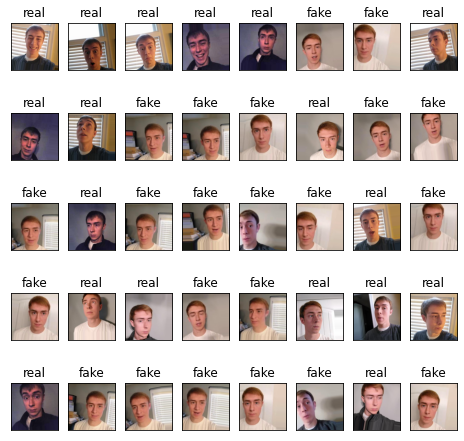

In [17]:
i = 0
figure = plt.figure(figsize=(8, 8))
columns = 8
rows = 5
ax = []
for batch in train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 256x256
        target_size=(256, 256),
        batch_size=1,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical'):
    i += 1
    lbl_index = np.nonzero(batch[1][0] == 1)[0][0]
    label = list(class_dictionary.keys())[list(class_dictionary.values()).index(lbl_index)]
    
    ax.append( figure.add_subplot(rows, columns, i) )
    imgplot = plt.imshow(image.array_to_img(batch[0][0,:,:,:]),cmap='gray')
    ax[-1].set_title(label)  # set title
    
    if i % (columns*rows) == 0:
        break
plt.setp(ax, xticks=[], yticks=[])
    
plt.show()

Found 174 images belonging to 2 classes.


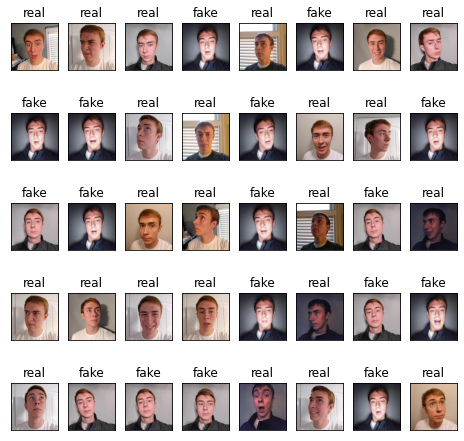

In [18]:
i = 0
figure = plt.figure(figsize=(8, 8))
columns = 8
rows = 5
ax = []
for batch in validate_datagen.flow_from_directory(
        # This is the target directory
        validation_dir,
        # All images will be resized to 256x256
        target_size=(256, 256),
        batch_size=1,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical'):
    i += 1
    lbl_index = np.nonzero(batch[1][0] == 1)[0][0]
    label = list(class_dictionary.keys())[list(class_dictionary.values()).index(lbl_index)]
    
    ax.append( figure.add_subplot(rows, columns, i) )
    imgplot = plt.imshow(image.array_to_img(batch[0][0,:,:,:]),cmap='gray')
    ax[-1].set_title(label)  # set title
    
    if i % (columns*rows) == 0:
        break
plt.setp(ax, xticks=[], yticks=[])
    
plt.show()

#Pretrained models

##VGG16

In [30]:
from tensorflow.keras.applications.vgg16 import VGG16
VGmodel = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))


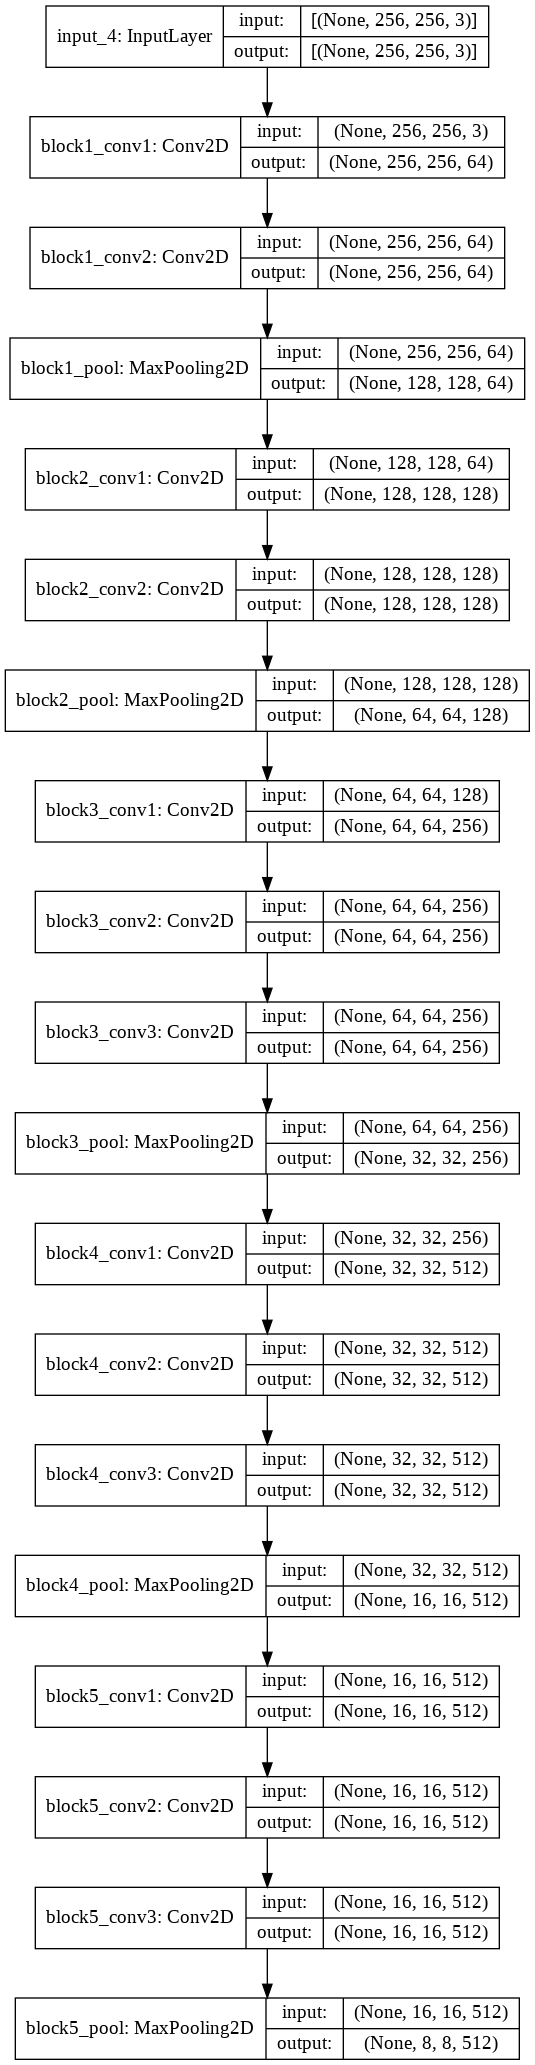

In [31]:
from tensorflow.keras.utils import plot_model
plot_model(VGmodel, show_layer_names=True, show_shapes=True)

In [23]:
# Empty placeholders for 400 Grayscale images and their labels
x_train = np.zeros((400, 256, 256, 3))
y_train = np.zeros((400, 2))
# Read everything from your generator
i = 0;
j = 0;
maxI = 400 / 4
for x, y in train_generator:
  #  print(x.shape)
  #  print(y)
  #  print(mydatax[j, :, :].shape)
   x_train[j] = x[0]
   y_train[j] = y[0]
   j+=1
   x_train[j] = x[1]
   y_train[j] = y[1]
   j+=1
   x_train[j] = x[2]
   y_train[j] = y[2]
   j+=1
   x_train[j] = x[3]
   y_train[j] = y[3]
   j+=1
   i+=1
   if i == maxI:
     break

In [52]:
# Empty placeholders for 400 Grayscale images and their labels
x_valid = np.zeros((400, 256, 256, 3))
y_valid = np.zeros((400, 2))
# Read everything from your generator
i = 0;
j = 0;
maxI = 400 / 4
for x, y in test_generator:
  #  print(x.shape)
  #  print(y)
  #  print(mydatax[j, :, :].shape)
   x_valid[j] = x[0]
   y_valid[j] = y[0]
   j+=1
   x_valid[j] = x[1]
   y_valid[j] = y[1]
   j+=1
   x_valid[j] = x[2]
   y_valid[j] = y[2]
   j+=1
   x_valid[j] = x[3]
   y_valid[j] = y[3]
   j+=1
   i+=1
   if i == maxI:
     break

In [26]:
# Empty placeholders for 400 Grayscale images and their labels
x_test = np.zeros((400, 256, 256, 3))
y_test = np.zeros((400, 2))
# Read everything from your generator
i = 0;
j = 0;
maxI = 400 / 4
for x, y in test_generator:
  #  print(x.shape)
  #  print(y)
  #  print(mydatax[j, :, :].shape)
   x_test[j] = x[0]
   y_test[j] = y[0]
   j+=1
   x_test[j] = x[1]
   y_test[j] = y[1]
   j+=1
   x_test[j] = x[2]
   y_test[j] = y[2]
   j+=1
   x_test[j] = x[3]
   y_test[j] = y[3]
   j+=1
   i+=1
   if i == maxI:
     break

In [53]:
x_test_vgg_output = VGmodel.predict(x_test, verbose = 1)
x_valid_vgg_output = VGmodel.predict(x_valid, verbose = 1)
x_train_vgg_output = VGmodel.predict(x_train, verbose = 1)

13/13 [==============================] - 2s 147ms/step


In [42]:

print(x_test_vgg_output.shape)
print(x_train_vgg_output.shape)
print(y_train.shape)
print(y_test.shape)

(400, 8, 8, 512)
(400, 8, 8, 512)
(400, 2)
(400, 2)


In [54]:
import numpy as np
x_test_new = np.reshape(x_test_vgg_output, (400, 8 * 8* 512))
x_train_new = np.reshape(x_train_vgg_output, (400, 8 * 8 * 512))
x_valid_new = np.reshape(x_valid_vgg_output, (400, 8 * 8 * 512))

In [55]:
print(x_test_new.shape)
print(x_train_new.shape)

(400, 32768)
(400, 32768)


In [58]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

new_model = models.Sequential()
new_model.add(layers.Dense(256, activation='relu', input_dim = 8 * 8 * 512))
new_model.add(layers.Dropout(0.5))
new_model.add(layers.Dense(2, activation='sigmoid'))

new_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = new_model.fit(x_train_new, y_train, epochs=128, batch_size=128, validation_data = (x_valid_new, y_valid))

Epoch 1/128
4/4 [==============================] - 1s 71ms/step - loss: 17.6264 - accuracy: 0.4625 - val_loss: 4.1930 - val_accuracy: 0.5450
Epoch 2/128
4/4 [==============================] - 0s 33ms/step - loss: 3.4750 - accuracy: 0.6419 - val_loss: 1.2777 - val_accuracy: 0.4925
Epoch 3/128
4/4 [==============================] - 0s 31ms/step - loss: 3.2508 - accuracy: 0.6158 - val_loss: 1.7659 - val_accuracy: 0.7050
Epoch 4/128
4/4 [==============================] - 0s 32ms/step - loss: 1.0485 - accuracy: 0.7565 - val_loss: 3.9873 - val_accuracy: 0.5500
Epoch 5/128
4/4 [==============================] - 0s 31ms/step - loss: 1.2902 - accuracy: 0.7014 - val_loss: 4.8692 - val_accuracy: 0.5700
Epoch 6/128
4/4 [==============================] - 0s 34ms/step - loss: 1.2325 - accuracy: 0.6881 - val_loss: 2.0466 - val_accuracy: 0.7225
Epoch 7/128
4/4 [==============================] - 0s 36ms/step - loss: 0.2072 - accuracy: 0.9187 - val_loss: 3.0615 - val_accuracy: 0.5700
Epoch 8/128
4/4 [==

#Residual Models

In [61]:
modelRes1 = Sequential()
modelRes1.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 3) ) )
modelRes1.add( MaxPool2D(4, 4) )
modelRes1.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
modelRes1.add( Flatten() )
modelRes1.add( Dense( 2, activation = 'relu' ) )
modelRes1.add( Dense( 2, activation = 'sigmoid' ) )
modelRes1.summary()
modelRes1.compile( optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
historyRes1 = modelRes1.fit(  train_generator, validation_data=validation_generator, callbacks=[callback], epochs = 35, batch_size = 64 )

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 16)        4624      
_________________________________________________________________
flatten_1 (Flatten)          (None, 59536)             0         
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 119074    
_________________________________________________________________
dense_23 (Dense)             (None, 2)                 6         
Total params: 124,600
Trainable params: 124,600
Non-trainable params: 0
_______________________________________________

In [62]:
input_img = Input(shape=(256,256,3))
output1 = Conv2D(32, (3, 3), activation='relu')(input_img)
for i in range(16):
    output2 = Conv2D(32, (3, 3), padding = 'same', activation='relu')(output1)
    output2 = BatchNormalization()(output2)
    output2 = Conv2D(32, (3, 3), padding = 'same', activation='relu')(output2)
    output2 = Dropout(0.2)(output2)
    output2 = add([output1, output2])
    output1 = output2
output3 = Flatten()(output2)
output4 = Dense(units = 16, activation = 'relu')(output3)
output5 = Dense(units = 16, activation = 'relu')(output4)
output6 = Dense(units = 2, activation = 'sigmoid')(output5)
modelRes2 = Model(inputs=input_img, outputs=output6)
modelRes2.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
print(modelRes2.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 254, 254, 32) 896         input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 254, 254, 32) 9248        conv2d_4[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 254, 254, 32) 128         conv2d_5[0][0]                   
______________________________________________________________________________________________

In [63]:
historyRes2 = modelRes2.fit( train_generator, validation_data=validation_generator, epochs = 4, batch_size = 10 )

Epoch 1/4
130/130 [==============================] - 43s 294ms/step - loss: 355.1091 - accuracy: 0.6060 - val_loss: 22.2562 - val_accuracy: 0.5805
Epoch 2/4
130/130 [==============================] - 38s 289ms/step - loss: 12.1274 - accuracy: 0.6081 - val_loss: 0.7951 - val_accuracy: 0.6264
Epoch 3/4
130/130 [==============================] - 38s 288ms/step - loss: 1.6680 - accuracy: 0.6023 - val_loss: 0.8478 - val_accuracy: 0.5920
Epoch 4/4
130/130 [==============================] - 38s 291ms/step - loss: 1.3747 - accuracy: 0.6832 - val_loss: 0.8367 - val_accuracy: 0.3793


In [64]:
input_img = Input(shape=(256,256,3))
output1 = Conv2D(16, (3, 3), activation='relu')(input_img)
for i in range(32):
    output2 = Conv2D(16, (3, 3), padding = 'same', activation='relu')(output1)
    output2 = BatchNormalization()(output2)
    output2 = Conv2D(16, (3, 3), padding = 'same', activation='relu')(output2)
    output2 = Dropout(0.3)(output2)
    output2 = add([output1, output2])
    output1 = output2
output3 = Flatten()(output2)
output4 = Dense(units = 16, activation = 'relu')(output3)
output5 = Dense(units = 16, activation = 'relu')(output4)
output6 = Dense(units = 2, activation = 'sigmoid')(output5)
modelRes3 = Model(inputs=input_img, outputs=output6)
modelRes3.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
print(modelRes3.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_37 (Conv2D)              (None, 254, 254, 16) 448         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 254, 254, 16) 2320        conv2d_37[0][0]                  
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 254, 254, 16) 64          conv2d_38[0][0]                  
____________________________________________________________________________________________

In [65]:
historyRes3 = modelRes3.fit( train_generator, validation_data=validation_generator, epochs = 8, batch_size = 10 )

Epoch 1/8
130/130 [==============================] - 53s 337ms/step - loss: 968.5845 - accuracy: 0.5374 - val_loss: 64.0843 - val_accuracy: 0.5805
Epoch 2/8
130/130 [==============================] - 43s 332ms/step - loss: 231.3441 - accuracy: 0.5933 - val_loss: 132.6977 - val_accuracy: 0.5805
Epoch 3/8
130/130 [==============================] - 43s 333ms/step - loss: 155.6957 - accuracy: 0.6642 - val_loss: 76.2610 - val_accuracy: 0.4080
Epoch 4/8
130/130 [==============================] - 43s 334ms/step - loss: 95.6112 - accuracy: 0.6920 - val_loss: 116.0097 - val_accuracy: 0.4598
Epoch 5/8
130/130 [==============================] - 43s 334ms/step - loss: 81.0572 - accuracy: 0.7068 - val_loss: 158.0211 - val_accuracy: 0.5747
Epoch 6/8
130/130 [==============================] - 43s 333ms/step - loss: 85.9740 - accuracy: 0.6642 - val_loss: 392.6678 - val_accuracy: 0.5000
Epoch 7/8
130/130 [==============================] - 43s 333ms/step - loss: 43.0885 - accuracy: 0.7343 - val_loss: 17

#Evaluate on the test set

In [67]:
testing_loss, testing_acc =new_model.evaluate(x_test_new, y_test, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Previous Phase Augmentation")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =modelRes1.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Residual Model 1")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =modelRes2.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Residual Model 2")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")
testing_loss, testing_acc =modelRes3.evaluate(test_generator, max_queue_size=10, steps=9, workers=1, use_multiprocessing=False, verbose=0)
print("___________________________________")
print("Residual Model 3")
print( 'testing_acc:', testing_acc )
print( 'testing_loss:', testing_loss )
print("===================================")

___________________________________
Previous Phase Augmentation
testing_acc: 0.7300000190734863
testing_loss: 6.036017417907715
___________________________________
Residual Model 1
testing_acc: 0.5780346989631653
testing_loss: 0.6809707283973694
___________________________________
Residual Model 2
testing_acc: 0.4219653308391571
testing_loss: 0.812375545501709
___________________________________
Residual Model 3
testing_acc: 0.5780346989631653
testing_loss: 0.6923723220825195


#Plot the curves

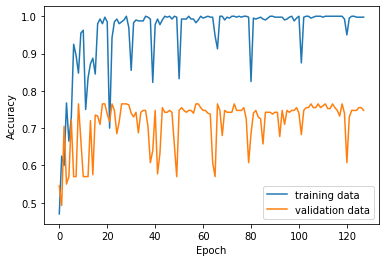

<Figure size 432x288 with 0 Axes>

In [72]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("original plot.png")

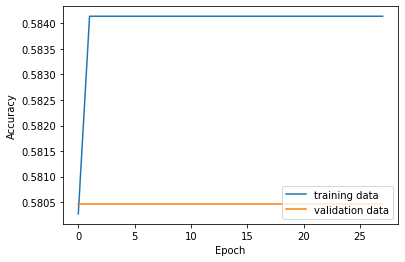

<Figure size 432x288 with 0 Axes>

In [69]:
plt.plot(historyRes1.history['accuracy'])
plt.plot(historyRes1.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot1.png")

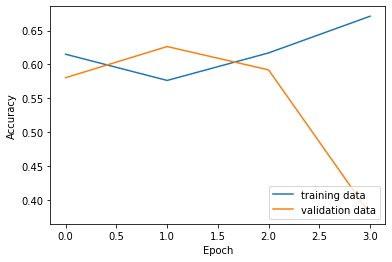

<Figure size 432x288 with 0 Axes>

In [70]:
plt.plot(historyRes2.history['accuracy'])
plt.plot(historyRes2.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot2.png")

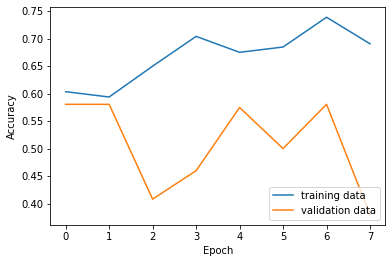

<Figure size 432x288 with 0 Axes>

In [71]:
plt.plot(historyRes3.history['accuracy'])
plt.plot(historyRes3.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("plot3.png")